In [37]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator
import seaborn as sns

In [38]:
import re

In [39]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [40]:
data_path = "/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/raw/"
exp_stage = "final"
task = "shared_control"

pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')

data_files = glob.glob(pattern)

In [41]:
def get_subject_label(file):
    
    match = re.search(r'/sub-(s\d{3})/', file)
    
    if match:
        subject_label = match.group(1)
        print("Subject label:", subject_label)
        return subject_label
    else:
        print("No subject label found.")
        return None

In [42]:
def string_to_numbers(string_data):
    if isinstance(string_data, float):  # Check if the input is already a float
        return [string_data]  # If it's a float, return it as a list
    string_data = string_data.strip("'")  # Remove leading and trailing single quotes
    numbers = [float(num) for num in string_data.split()]
    return numbers

In [43]:
def process_trial_data(data, block, min_delay=0.175, threshold_reduction=0.30):
    trial_results = {}
    ssrt_list = []

    for idx, row in data.iterrows():
        trial_number = idx
        stop_onset = row['SSD_mean']
        time_stamps = row['time_stamps_raw']
        pressures_raw = row['pressures_raw']
        condition = row['condition']
        distances_raw = row['distances_raw']

         # Find the index corresponding to the stop onset time
        if stop_onset is not None:
            stop_onset_idx = next((i for i, t in enumerate(time_stamps) if t >= stop_onset), None)
        else:
            stop_onset_idx = None

        # Calculate the minimum time to start checking for inhibition
        start_check_time = stop_onset + min_delay

        # Find the index where to start checking (first index after the start_check_time)
        index_of_start_check = next((i for i, t in enumerate(time_stamps) if t >= start_check_time), None)

        index_of_inhibition = None
        stop_moment = None
        moment_of_inhibition = None
        stop_moment_idx = None
        duration_of_inhibition = None

        # Find the moment of inhibition (first point where pressure reduces by at least 30% monotonically in one of the next five points)
        if index_of_start_check is not None:
            for i in range(index_of_start_check, len(pressures_raw) - 1):
                current_pressure = pressures_raw[i]
                target_pressure = current_pressure * (1 - threshold_reduction)
                
                # Check if the pressure decreases to below the target
                if pressures_raw[i] > target_pressure:
                    
                    # Check if the next pressures monotonically decrease
                    decreasing = all(pressures_raw[j] <= pressures_raw[j-1] for j in range(i+1, min(i+5, len(pressures_raw))))
                    
                    # Also check if any pressure in the next five is below the target pressure
                    if decreasing and any(pressures_raw[j] <= target_pressure for j in range(i+1, min(i+5, len(pressures_raw)))):
                        moment_of_inhibition = time_stamps[i]
                        index_of_inhibition = i
                        break


        # Find the end of inhibition (first zero pressure after the start of inhibition)
        if index_of_inhibition is not None:
            stop_moment_indices = [i for i in range(index_of_inhibition, len(pressures_raw)) if pressures_raw[i] == 0]
            if stop_moment_indices:
                stop_moment = time_stamps[stop_moment_indices[0]]
                stop_moment_idx = stop_moment_indices[0]

        # Find the duration of inhibition (time between moment of inhibition and end of inhibition)
        if moment_of_inhibition is not None and stop_moment is not None:
            duration_of_inhibition = stop_moment - moment_of_inhibition
        else:
            duration_of_inhibition = np.nan
                
        # Calculate SSRT if both inhibition start and stop moments are identified
        if stop_onset is not None and moment_of_inhibition is not None:
            ssrt = moment_of_inhibition - stop_onset
            ssrt_list.append(ssrt)
        else:
            print(f'Trial {idx} has no SSRT, condition = {condition} // block = {block}')
            ssrt = np.nan
            ssrt_list.append(ssrt)
        
        # Calculate Go Task Measure at the Onset of the Stop Signal 1 - fully within the ring, 0 - outside the ring
        critical_distance = 2 - 0.8 # this should be the distance that needs to be cleared to be outside the circle
        if stop_onset is not None:
            stop_distance = distances_raw[stop_onset_idx]
            if abs(stop_distance) > critical_distance:
                go_task_accuracy_at_stop_onset = 0
            else:
                go_task_accuracy_at_stop_onset = 1
        else:
            stop_distance = np.nan
        
        # Calculate Go Task Accuracy throughout the task until the Stop Signal Appears 1 - within the ring the whole time, 0 - never in the ring
        # Also find the proportion of times the ball was ahead of or behind the ring before the stop onset
        inside_ring_count = 0
        before_ring_count = 0
        after_ring_count = 0
        count = 0
        if stop_onset is not None:
            while count < stop_onset_idx:
                distance = distances_raw[count]
                if abs(distance) <= critical_distance:
                    inside_ring_count += 1
                elif distance < -critical_distance:
                    before_ring_count += 1
                elif distance > critical_distance:
                    after_ring_count += 1
                count += 1
            go_task_accuracy_before_stop_onset = inside_ring_count / count 
            ball_before_ring_proportion_before_stop_onset = before_ring_count / count
            ball_after_ring_proportion_before_stop_onset = after_ring_count / count
        else:
            go_task_accuracy_before_stop_onset = np.nan
            ball_before_ring_proportion_before_stop_onset = np.nan
            ball_after_ring_proportion_before_stop_onset = np.nan

        # Calculate Go Task Accuracy after the Stop Onset until the end of the task 1 - within the ring the whole time, 0 - never in the ring
        # Also find the proportion of times the ball was ahead of or behind the ring after the stop onset
        inside_ring_count = 0
        if stop_onset is not None:
            count = stop_onset_idx + 1
            while count < len(distances_raw):
                distance = distances_raw[count]
                if abs(distance) <= critical_distance:
                    inside_ring_count += 1
                elif distance < -critical_distance:
                    before_ring_count += 1
                elif distance > critical_distance:
                    after_ring_count += 1
                count += 1
            go_task_accuracy_after_stop_onset = inside_ring_count / (len(distances_raw) - stop_onset_idx)
            ball_before_ring_proportion_after_stop_onset = before_ring_count / (len(distances_raw) - stop_onset_idx)
            ball_after_ring_proportion_after_stop_onset = after_ring_count / (len(distances_raw) - stop_onset_idx)
        else:
            go_task_accuracy_after_stop_onset = np.nan
            ball_before_ring_proportion_after_stop_onset = np.nan
            ball_after_ring_proportion_after_stop_onset = np.nan

        # Calculate Go Task Accuracy until the stop signal appears at each 100ms time interval.
        # Also, for each trial, determine which 100ms interval the stop onset was in
        accuracies_at_intervals = []
        stops_at_intervals = []
        interval_start_idx = 0
        interval_end_time = time_stamps[0] + 0.1  # 100 ms interval
        while interval_start_idx < len(time_stamps) and time_stamps[interval_start_idx] <= stop_onset:
            inside_ring_count = 0
            count = interval_start_idx
            if(stop_onset <= interval_end_time): #checking which interval the stop onset is in
                stop = 1
            else:
                stop = 0
            # Loop through the time stamps within the current 100 ms interval
            while count < len(time_stamps) and time_stamps[count] <= interval_end_time and time_stamps[count] < stop_onset:
                distance = distances_raw[count]
                if abs(distance) <= critical_distance:
                    inside_ring_count += 1
                count += 1
            # Calculate accuracy for this interval
            if count > interval_start_idx:  # Avoid division by zero
                go_task_accuracy = inside_ring_count / (count - interval_start_idx)
            else:
                go_task_accuracy = np.nan  # If no data points in this interval
            accuracies_at_intervals.append(go_task_accuracy)
            stops_at_intervals.append(stop)
            # Move to the next 100 ms interval
            interval_start_idx = count
            interval_end_time += 0.1  # Move the interval end time by 100 ms

        # Store the results in the dictionary
        trial_results[trial_number] = {
            'stop_onset': stop_onset,
            'stop_moment': stop_moment,
            'stop_moment_idx': stop_moment_idx,
            'moment_of_inhibition': moment_of_inhibition,
            'index_of_inhibition': index_of_inhibition,
            'duration_of_inhibition': duration_of_inhibition,
            'distances_raw': distances_raw,
            'pressures_raw': pressures_raw,
            'time_stamps_raw': time_stamps,
            'condition': condition,
            'post_buffer_stamp': start_check_time,
            'go_task_accuracy_at_stop_onset': go_task_accuracy_at_stop_onset,
            'go_task_accuracy_before_stop_onset': go_task_accuracy_before_stop_onset,
            'go_task_accuracy_after_stop_onset': go_task_accuracy_after_stop_onset,
            'ball_before_ring_proportion_before_stop_onset': ball_before_ring_proportion_before_stop_onset,
            'ball_after_ring_proportion_before_stop_onset': ball_after_ring_proportion_before_stop_onset,
            'ball_before_ring_proportion_after_stop_onset': ball_before_ring_proportion_after_stop_onset,
            'ball_after_ring_proportion_after_stop_onset': ball_after_ring_proportion_after_stop_onset,
            'accuracies_at_intervals': accuracies_at_intervals,
            'stops_at_intervals': stops_at_intervals,
            'ssrt': ssrt
        }

    return trial_results, ssrt_list


In [44]:
shared_control_metrics = {}

for file in data_files:
    subject_label = get_subject_label(file)
    
    df = pd.read_csv(file)
    
    # some post processing
    df['phase_raw'] = df['phase_raw'].str.strip("'")
    df['block_raw'] = df['block_raw'].str.strip("'")
    
    df_test = df.query("phase_raw == 'test'")
    block_1 = df_test.query("block_raw == 'block 1'")
    block_2 = df_test.query("block_raw == 'block 2'")
    block_1 = block_1.reset_index(drop=True)
    block_2 = block_2.reset_index(drop=True)

    task_dfs = [block_1, block_2]
    
    for df in task_dfs:
        if 'ai' in df['condition'].values:
            ai_data = df.copy()
            ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
            ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
            ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
        else:
            control_data = df.copy()
            control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
            control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
            control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)
    
    shared_control_metrics[subject_label] = {'ai': {'data': ai_data}, 'non_ai': {'data': control_data}}
    
    for block in shared_control_metrics[subject_label].keys():
        trial_results, ssrt_list = process_trial_data(shared_control_metrics[subject_label][block]['data'], block=block)
        shared_control_metrics[subject_label][block]['trial_results'] = trial_results
        shared_control_metrics[subject_label][block]['ssrt_list'] = ssrt_list 
    
    print(f"Done: {subject_label}")

Subject label: s042
Trial 8 has no SSRT, condition = ai // block = ai
Trial 65 has no SSRT, condition = ai // block = ai
Trial 76 has no SSRT, condition = ai // block = ai
Trial 1 has no SSRT, condition = stop // block = non_ai
Trial 68 has no SSRT, condition = stop // block = non_ai
Done: s042
Subject label: s029
Trial 9 has no SSRT, condition = ai // block = ai
Trial 49 has no SSRT, condition = ai // block = ai
Done: s029
Subject label: s016
Trial 73 has no SSRT, condition = ai // block = ai
Trial 93 has no SSRT, condition = ai // block = ai
Trial 35 has no SSRT, condition = stop // block = non_ai
Done: s016
Subject label: s011
Trial 14 has no SSRT, condition = stop // block = non_ai
Done: s011
Subject label: s018
Trial 34 has no SSRT, condition = stop // block = non_ai
Trial 35 has no SSRT, condition = stop // block = non_ai
Trial 58 has no SSRT, condition = stop // block = non_ai
Done: s018
Subject label: s027
Trial 5 has no SSRT, condition = ai // block = ai
Trial 18 has no SSRT, 

### testing go success

In [45]:
shared_control_metrics.keys()

dict_keys(['s042', 's029', 's016', 's011', 's018', 's027', 's020', 's043', 's021', 's019', 's026', 's010', 's028', 's017', 's035', 's032', 's004', 's005', 's033', 's034', 's012', 's015', 's023', 's024', 's041', 's025', 's022', 's014', 's013', 's040', 's031', 's036', 's009', 's007', 's038', 's006', 's039', 's037', 's008', 's030'])

In [46]:
shared_control_metrics['s016'].keys()

dict_keys(['ai', 'non_ai'])

In [47]:
shared_control_metrics['s016']['non_ai'].keys()

dict_keys(['data', 'trial_results', 'ssrt_list'])

In [48]:
shared_control_metrics['s016']['non_ai']['trial_results'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [49]:
shared_control_metrics['s016']['non_ai']['trial_results'][33]['go_task_accuracy_at_stop_onset']

0

In [50]:
total_successes = 0
total_trials = len(trial_results)

for trial_id in shared_control_metrics['s016']['ai']['trial_results']:
    # Assume each trial result dictionary has a 'go_task_accuracy_at_stop_onset' key
    total_successes += shared_control_metrics['s016']['ai']['trial_results'][trial_id]['go_task_accuracy_at_stop_onset']

average_success_rate_at_stop_moment = total_successes / total_trials


In [51]:
#Check if these add up to 1 for a given trial
print(shared_control_metrics['s016']['ai']['trial_results'][4]['go_task_accuracy_before_stop_onset'])
print(shared_control_metrics['s016']['ai']['trial_results'][4]['ball_before_ring_proportion_before_stop_onset'])
print(shared_control_metrics['s016']['ai']['trial_results'][4]['ball_after_ring_proportion_before_stop_onset'])

0.7596153846153846
0.2403846153846154
0.0


In [52]:
average_success_rate_at_stop_moment

0.93

## Grabbing SSRT and other metrics across conditions

In [53]:
def grab_mean_metric(measure):

    """
    Function to find the mean of a measure 'measure' which should be inputted as a 
    string (eg. 'ssrt' or 'duration_of_inhibition')across non_ai trials, ai_condition_stop_trials,
    and ai_condition_ai_trials for each subject. Outputs a csv file with the subject number and three columns
    with the mean of the measure in each of the three trials in each row.
    """ 

    condition_measure = {}

    for subject in shared_control_metrics.keys():
        non_ai_condition_stop_trials = []
        ai_condition_stop_trials = []
        ai_condition_ai_trials = []
        
        for block in shared_control_metrics[subject].keys():
            
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():
                
                if block == 'non_ai':
                    non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                    ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                    ai_condition_ai_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                else:
                    print("Something fucked up boss...")
            
        avg_ai_ai = np.nanmean(ai_condition_ai_trials)
        avg_ai_stop = np.nanmean(ai_condition_stop_trials)
        avg_non_ai_stop = np.nanmean(non_ai_condition_stop_trials)
        
        condition_measure[subject] = {f'non_ai_stop_{measure}': avg_non_ai_stop, f'ai_stop_{measure}': avg_ai_stop, f'ai_ai_{measure}': avg_ai_ai}

        df = pd.DataFrame(condition_measure).T
        df = df.sort_index()
        df.loc['mean'] = df.mean()
        
        if(measure == 'go_task_accuracy_after_stop_onset'):
            df = df.drop('ai_ai_go_task_accuracy_after_stop_onset', axis = 1)
        df.to_csv(f'output/shared_control_metrics_{measure}.csv')

In [54]:
def grab_metric_at_intervals(measure):

    """
    Function to calculate the mean accuracies at each 100ms time interval across 
    non_ai stop, ai_condition_stop_trials, and ai_condition_ai_trials for each subject.
    Outputs three separate CSV files: one for each condition (non-ai stop, ai stop, and ai ai).
    The rows represent the subject numbers, and the columns represent the time intervals 
    (0-100ms, 100-200ms, etc.).
    """
    
    # Initialize dictionaries to store accuracies for each condition
    non_ai_stop = {}
    ai_stop = {}
    ai_ai = {}

    # Loop through all subjects
    for subject in shared_control_metrics.keys():
        non_ai_condition_stop_trials = []
        ai_condition_stop_trials = []
        ai_condition_ai_trials = []
        
        # Loop through the blocks and extract accuracies at intervals
        for block in shared_control_metrics[subject].keys():
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():
                
                # Collect accuracies for the respective conditions
                if block == 'non_ai':
                    non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                    ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                    ai_condition_ai_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
        
        # Find the maximum interval length to pad the lists to the same length
        max_length = max(
            max([len(lst) for lst in non_ai_condition_stop_trials], default=0),
            max([len(lst) for lst in ai_condition_stop_trials], default=0),
            max([len(lst) for lst in ai_condition_ai_trials], default=0)
        )

        if(measure == 'accuracies_at_intervals'):
        # Pad the trials with NaN to make sure they are the same length
            non_ai_condition_stop_trials = [np.pad(np.array(lst, dtype=float), (0, max_length - len(lst)), constant_values=np.nan) for lst in non_ai_condition_stop_trials]
            ai_condition_stop_trials = [np.pad(np.array(lst, dtype=float), (0, max_length - len(lst)), constant_values=np.nan) for lst in ai_condition_stop_trials]
            ai_condition_ai_trials = [np.pad(np.array(lst, dtype=float), (0, max_length - len(lst)), constant_values=np.nan) for lst in ai_condition_ai_trials]
        else:
        # Pad the trials with 0 to make sure they are the same length
            non_ai_condition_stop_trials = [np.pad(lst, (0, max_length - len(lst)), constant_values=0) for lst in non_ai_condition_stop_trials]
            ai_condition_stop_trials = [np.pad(lst, (0, max_length - len(lst)), constant_values=0) for lst in ai_condition_stop_trials]
            ai_condition_ai_trials = [np.pad(lst, (0, max_length - len(lst)), constant_values=0) for lst in ai_condition_ai_trials]

        # Calculate the mean accuracy at each interval for each condition
        if(measure == 'accuracies_at_intervals'):
            if non_ai_condition_stop_trials:
                non_ai_stop[subject] = np.nanmean(np.vstack(non_ai_condition_stop_trials), axis=0)
            if ai_condition_stop_trials:
                ai_stop[subject] = np.nanmean(np.vstack(ai_condition_stop_trials), axis=0)
            if ai_condition_ai_trials:
                ai_ai[subject] = np.nanmean(np.vstack(ai_condition_ai_trials), axis=0)
        else:
            if non_ai_condition_stop_trials:
                non_ai_stop[subject] = np.nansum(np.vstack(non_ai_condition_stop_trials), axis=0)
            if ai_condition_stop_trials:
                ai_stop[subject] = np.nansum(np.vstack(ai_condition_stop_trials), axis=0)
            if ai_condition_ai_trials:
                ai_ai[subject] = np.nansum(np.vstack(ai_condition_ai_trials), axis=0)

    # Convert dictionaries into DataFrames for each condition
    time_intervals = [f"{i * 100}-{(i + 1) * 100}ms" for i in range(max_length)]

    df_non_ai_stop = pd.DataFrame.from_dict(non_ai_stop, orient='index')
    df_non_ai_stop.columns = time_intervals
    df_non_ai_stop.index.name = 'subject'
    df_non_ai_stop = df_non_ai_stop.sort_values(by='subject')
    df_non_ai_stop.loc['mean across all subjects'] = df_non_ai_stop.mean()

    df_ai_stop = pd.DataFrame.from_dict(ai_stop, orient='index')
    df_ai_stop.columns = time_intervals
    df_ai_stop.index.name = 'subject'
    df_ai_stop = df_ai_stop.sort_values(by='subject')
    df_ai_stop.loc['mean across all subjects'] = df_ai_stop.mean()

    df_ai_ai = pd.DataFrame.from_dict(ai_ai, orient='index')
    df_ai_ai.columns = time_intervals
    df_ai_ai.index.name = 'subject'
    df_ai_ai = df_ai_ai.sort_values(by='subject')
    df_ai_ai.loc['mean across all subjects'] = df_ai_ai.mean()

    # Save the DataFrames as CSV files
    df_non_ai_stop.to_csv(f"output/shared_control_metrics_non_ai_stop_{measure}.csv")
    df_ai_stop.to_csv(f'output/shared_control_metrics_ai_stop_{measure}.csv')
    df_ai_ai.to_csv(f'output/shared_control_metrics_ai_ai_{measure}.csv')



In [55]:
grab_mean_metric('ssrt')

In [56]:
grab_mean_metric('duration_of_inhibition')

In [57]:
grab_mean_metric('go_task_accuracy_before_stop_onset')

In [58]:
grab_mean_metric('go_task_accuracy_at_stop_onset')

In [59]:
grab_mean_metric('go_task_accuracy_after_stop_onset')

In [60]:
grab_mean_metric('ball_before_ring_proportion_before_stop_onset')

In [61]:
grab_mean_metric('ball_after_ring_proportion_before_stop_onset')

In [62]:
grab_mean_metric('ball_before_ring_proportion_after_stop_onset')

In [63]:
grab_mean_metric('ball_after_ring_proportion_after_stop_onset')

In [64]:
grab_metric_at_intervals('accuracies_at_intervals')

/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_16969/2514044269.py:57: RuntimeWarning: Mean of empty slice
  non_ai_stop[subject] = np.nanmean(np.vstack(non_ai_condition_stop_trials), axis=0)
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_16969/2514044269.py:59: RuntimeWarning: Mean of empty slice
  ai_stop[subject] = np.nanmean(np.vstack(ai_condition_stop_trials), axis=0)
/var/folders/8s/r02gjh_90hqdkx4nmh9szbsw0000gn/T/ipykernel_16969/2514044269.py:61: RuntimeWarning: Mean of empty slice
  ai_ai[subject] = np.nanmean(np.vstack(ai_condition_ai_trials), axis=0)


In [65]:
grab_metric_at_intervals('stops_at_intervals')

### Displaying Trials for QC

In [66]:
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator

In [67]:
def plot_trial_pressure_individual(trial_data, trial_number, ax, color):
    pressures_raw = trial_data['pressures_raw']
    time_stamps_raw = trial_data['time_stamps_raw']
    stop_onset_time = trial_data.get('stop_onset', None)
    moment_of_inhibition = trial_data.get('moment_of_inhibition', None)
    stop_moment = trial_data.get('stop_moment', None)
    post_buffer_stamp = trial_data.get('post_buffer_stamp', None)

    # Plotting all pressures
    ax.plot(time_stamps_raw, pressures_raw, label=f'Trial {trial_number}', color=color)

    # Adding vertical dotted lines at critical points if available
    if stop_onset_time is not None:
        ax.axvline(x=stop_onset_time, color='black', linestyle='dotted', linewidth=2, label='Stop Onset')
    if moment_of_inhibition is not None:
        ax.axvline(x=moment_of_inhibition, color='green', linestyle='dotted', linewidth=2, label='Moment of Inhibition')
    if stop_moment is not None:
        ax.axvline(x=stop_moment, color='red', linestyle='dotted', linewidth=2, label='Stop Moment')
    if post_buffer_stamp is not None:
        ax.axvline(x=post_buffer_stamp, color='purple', linestyle='dotted', linewidth=2, label='Post Buffer Stamp')

    # Setting axis labels, title, and grid
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Raw Pressure')
    ax.set_title(f'Trial {trial_number}')
    ax.legend()
    ax.grid(True)

    # Set fixed y-axis and x-axis limits
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlim(0, 6.3)  # Set x-axis limits from 0 to 6 seconds

    # Set x-axis major and minor ticks
    ax.xaxis.set_major_locator(MultipleLocator(1))  # Major ticks at every second
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))  # Minor ticks at every 100 ms

In [68]:
def display_subject_trials(subject, block, data = shared_control_metrics):
    
    # plotting individual AI block trials
    num_trials_ai = len(data[subject][block]['trial_results'])
    num_cols = 2
    num_rows = (num_trials_ai + 1) // 2  # Add 1 to round up

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), squeeze=False)  # Ensure axs is always a 2D array
    
    # notes. if its an AI trial the trial will be blue, if its a stop then red
    ai_color = 'blue'
    stop_color = 'red'

    for i, (trial_number, trial_data) in enumerate(data[subject][block]['trial_results'].items()):
        row = i // num_cols
        col = i % num_cols
        condition = trial_data['condition']
        color = ai_color if condition == 'ai' else stop_color
        plot_trial_pressure_individual(trial_data, trial_number, axs[row, col], color=color)

    plt.tight_layout()
    plt.show()

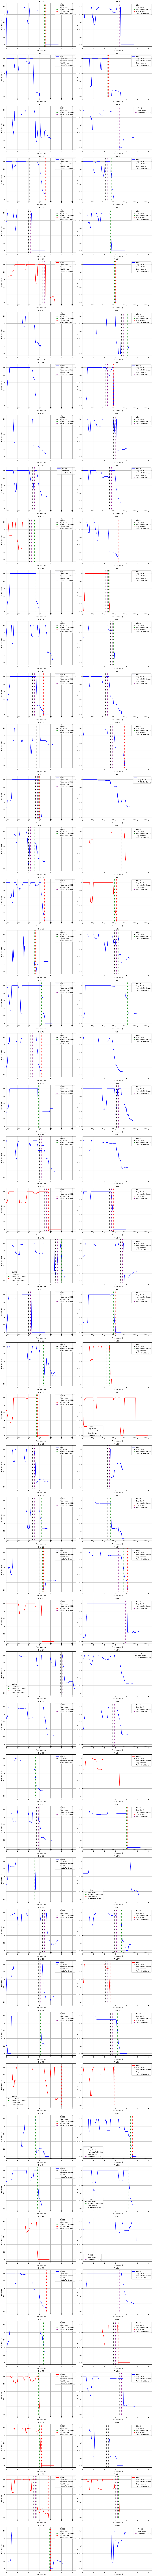

In [69]:
subject = 's027'
condition = 'ai'

display_subject_trials(subject, condition, data = shared_control_metrics)

In [70]:
def plot_distributions(measure):
    """
    Function to plot histograms for individual trial estimates of SSRT and duration of inhibition 
    across non_ai stop, ai stop, and ai ai conditions for each subject.
    Saves all the plots together in one large image file.
    
    Parameters:
    - measure: The measure to plot (e.g., 'SSRT', 'inhibition_duration').
    """

    # Sort the subjects in ascending order
    sorted_subjects = sorted(shared_control_metrics.keys(), key=lambda x: int(x[1:]))
    
    num_subjects = len(sorted_subjects)
    
    # Set up the figure size (adjust depending on how many subjects you have)
    fig, axes = plt.subplots(num_subjects, 3, figsize=(15, num_subjects * 3))
    
    # Loop through all subjects
    for i, subject in enumerate(sorted_subjects):
        
        non_ai_condition_stop_trials = []
        ai_condition_stop_trials = []
        ai_condition_ai_trials = []

        # Loop through the blocks and extract data for histograms
        for block in shared_control_metrics[subject].keys():
            for trial in shared_control_metrics[subject][block]['trial_results'].keys():
                
                # Collect data for the respective conditions
                if block == 'non_ai':
                    non_ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'stop'):
                    ai_condition_stop_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])
                    
                elif (block == 'ai') and (shared_control_metrics[subject][block]['trial_results'][trial]['condition'] == 'ai'):
                    ai_condition_ai_trials.append(shared_control_metrics[subject][block]['trial_results'][trial][measure])

        # Combine all trial data to get consistent axes
        all_trials = non_ai_condition_stop_trials + ai_condition_stop_trials + ai_condition_ai_trials
        if len(all_trials) > 0:
            x_min = min(all_trials)
            x_max = max(all_trials)

            # Plot histograms for each condition in subplots
            sns.histplot(non_ai_condition_stop_trials, kde=True, ax=axes[i, 0], binwidth=0.009, edgecolor='black')
            axes[i, 0].set_title(f"Non-AI Stop Trials (Sub {subject})")
            axes[i, 0].set_xlabel(f"{measure} (s)")
            axes[i, 0].set_ylabel("Frequency")
            axes[i, 0].set_xlim(x_min, x_max)

            # Calculate and display the mean RT for Non-AI Stop Trials
            mean_non_ai = np.nanmean(non_ai_condition_stop_trials)
            axes[i, 0].text(0.95, 0.95, f'Mean: {mean_non_ai}', 
                            transform=axes[i, 0].transAxes, fontsize=10, 
                            verticalalignment='top', horizontalalignment='right')
            
            sns.histplot(ai_condition_stop_trials, kde=True, ax=axes[i, 1], binwidth=0.009, edgecolor='black')
            axes[i, 1].set_title(f"AI Stop Trials (Sub {subject})")
            axes[i, 1].set_xlabel(f"{measure} (s)")
            axes[i, 1].set_ylabel("Frequency")
            axes[i, 1].set_xlim(x_min, x_max)

            # Calculate and display the mean RT for AI Stop Trials
            mean_ai_stop = np.nanmean(ai_condition_stop_trials)
            axes[i, 1].text(0.95, 0.95, f'Mean: {mean_ai_stop}', 
                            transform=axes[i, 1].transAxes, fontsize=10, 
                            verticalalignment='top', horizontalalignment='right')
            
            sns.histplot(ai_condition_ai_trials, kde=True, ax=axes[i, 2], binwidth=0.009, edgecolor='black')
            axes[i, 2].set_title(f"AI AI Trials (Sub {subject})")
            axes[i, 2].set_xlabel(f"{measure} (s)")
            axes[i, 2].set_ylabel("Frequency")
            axes[i, 2].set_xlim(x_min, x_max)

            # Calculate and display the mean RT for AI AI Trials
            mean_ai_ai = np.nanmean(ai_condition_ai_trials)
            axes[i, 2].text(0.95, 0.95, f'Mean: {mean_ai_ai}', 
                            transform=axes[i, 2].transAxes, fontsize=10, 
                            verticalalignment='top', horizontalalignment='right')

    # Adjust layout and spacing
    plt.tight_layout()

    # Save the combined plot as one image
    plt.savefig(f'output/all_{measure}_distributions.png', dpi=300)

    #plt.show()

    # Close the figure to free up memory
    plt.close()

# Call the function to plot
plot_distributions('ssrt')


In [71]:
plot_distributions('duration_of_inhibition')

In [72]:
import subprocess
import re

# Run pip freeze and capture output
result = subprocess.run(['pip', 'freeze'], capture_output=True, text=True)

# Use a regex to remove lines that include 'file:///'
cleaned_output = re.sub(r' @ file://[^\n]+', '', result.stdout)

# Write the cleaned output to a new requirements.txt file
with open('requirements.txt', 'w') as f:
    f.write(cleaned_output)

print("Cleaned requirements.txt has been generated.")

Cleaned requirements.txt has been generated.
